# Cats vs. Dogs dataset

In [1]:
import tensorflow as tf
# Ensure TF does not see GPU and grab all GPU memory.
tf.config.set_visible_devices([], device_type='GPU')

import tensorflow_datasets as tfds

data_dir = '/tmp/tfds'

# As the dataset does not contain any train/test split
# we make our own split into train and test dataset.
# as_supervised=True gives us the (image, label) as a tuple instead of a dict
data, info = tfds.load(name="cats_vs_dogs",
                       data_dir=data_dir,
                       split=["train[:80%]", "train[80%:]"],
                       as_supervised=True,
                       with_info=True)

(cats_dogs_data_train, cats_dogs_data_test) = data

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /tmp/tfds/cats_vs_dogs/4.0.1.incompleteOWQJDQ/cats_vs_dogs-train.tfrecord*...:   0%|          | 0/23…

Dataset cats_vs_dogs downloaded and prepared to /tmp/tfds/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


In [2]:
info

tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    full_name='cats_vs_dogs/4.0.1',
    description="""
    A large set of images of cats and dogs. There are 1738 corrupted images that are dropped.
    """,
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    data_dir=PosixGPath('/tmp/tmpqea2awfetfds'),
    file_format=tfrecord,
    download_size=786.67 MiB,
    dataset_size=1.04 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=23262, num_shards=16>,
    },
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, John (JD) and Howell, Jon and Saul, Jared},
    

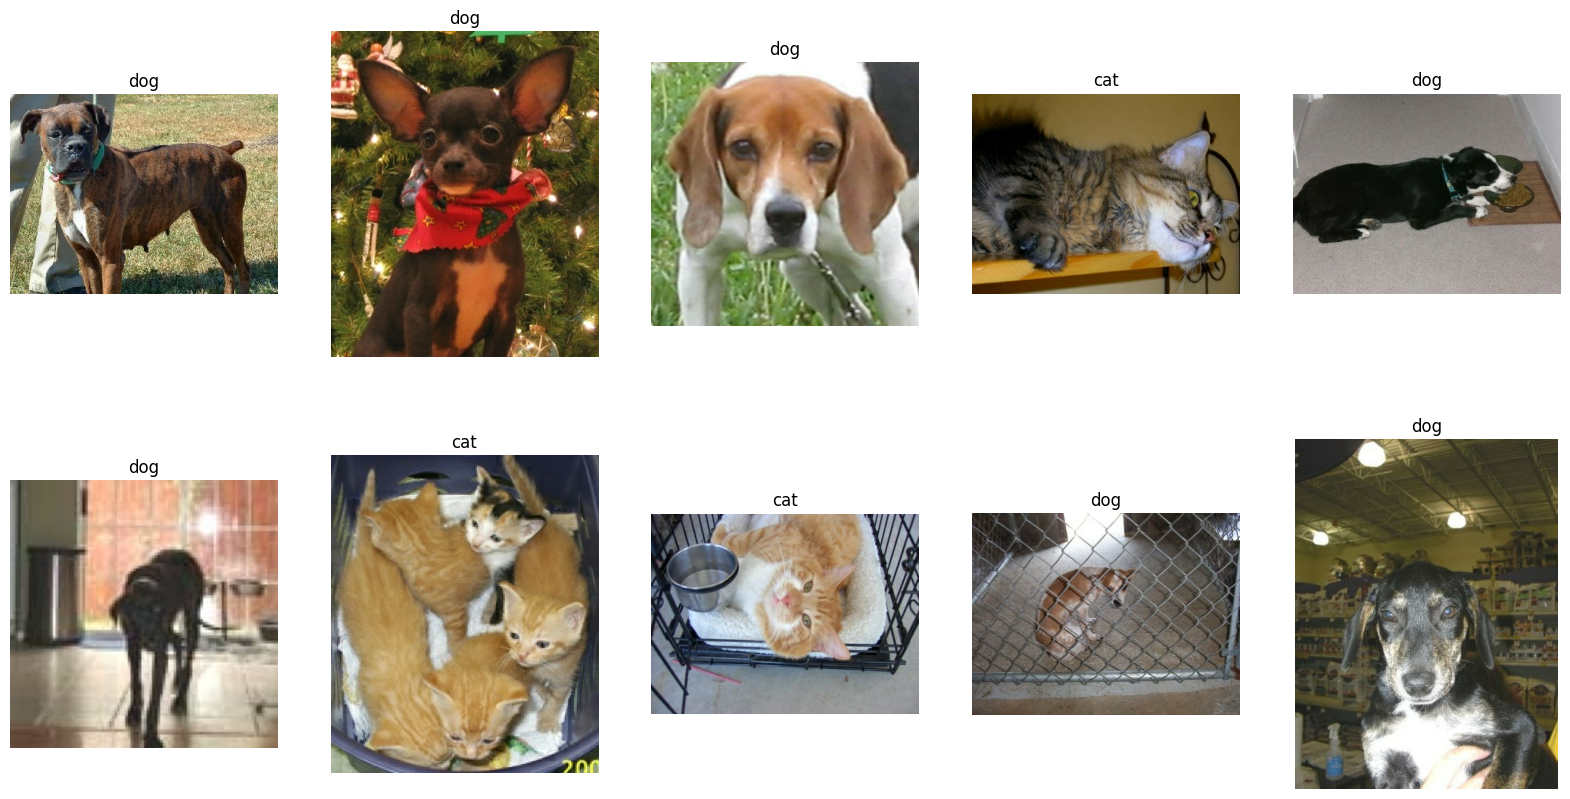

In [3]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]

CLASS_NAMES = ['cat', 'dog']
ROWS = 2
COLS = 5

i = 0
fig, ax = plt.subplots(ROWS, COLS)
for image, label in cats_dogs_data_train.take(ROWS*COLS):
    ax[int(i/COLS), i%COLS].axis('off')
    ax[int(i/COLS), i%COLS].set_title(CLASS_NAMES[label])
    ax[int(i/COLS), i%COLS].imshow(image)
    i += 1

plt.show()

In [4]:
HEIGHT = 200
WIDTH  = 200
CHANNELS = 3
NUM_PIXELS = HEIGHT * WIDTH * CHANNELS
NUM_LABELS = info.features['label'].num_classes

In [5]:
import jax.numpy as jnp

In [6]:
def one_hot(x, k, dtype=jnp.float32):
  """Create a one-hot encoding of x of size k."""
  return jnp.array(x[:, None] == jnp.arange(k), dtype)

def preprocess(img, label):
  """Resize and preprocess images."""
  return tf.image.resize(img, [HEIGHT, WIDTH]) / 255.0, label

In [7]:
cats_dogs_data_train_vis = cats_dogs_data_train.map(preprocess)

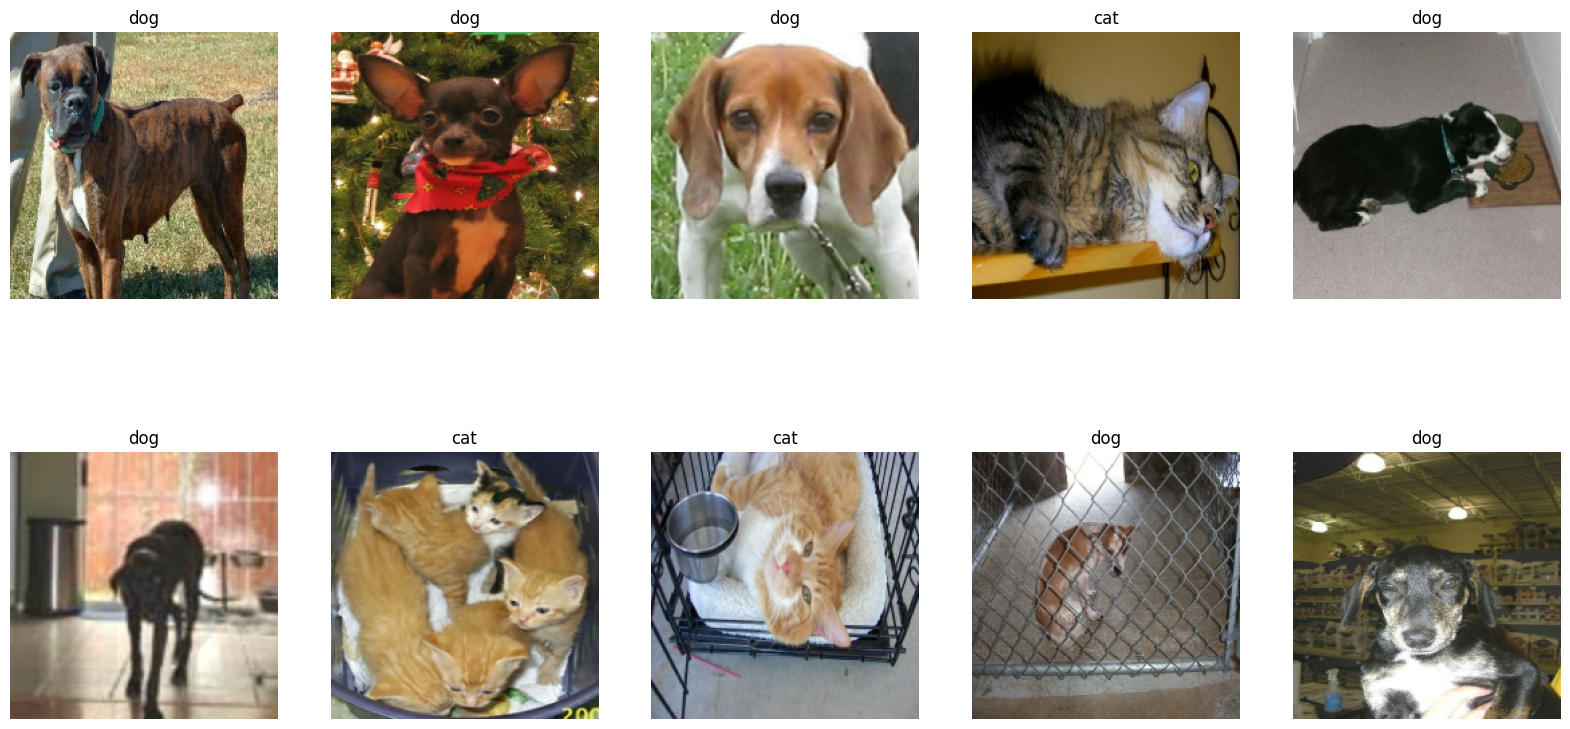

In [8]:
i = 0
fig, ax = plt.subplots(ROWS, COLS)
for image, label in cats_dogs_data_train_vis.take(ROWS*COLS):
    ax[int(i/COLS), i%COLS].axis('off')
    ax[int(i/COLS), i%COLS].set_title(CLASS_NAMES[label])
    ax[int(i/COLS), i%COLS].imshow(image)
    i += 1

plt.show()

In [9]:
train_data = tfds.as_numpy(cats_dogs_data_train.map(preprocess).batch(32).prefetch(1))
test_data  = tfds.as_numpy(cats_dogs_data_test.map(preprocess).batch(32).prefetch(1))

# Generating random noise

In [10]:
import jax

In [11]:
batch_images,batch_labels = next(iter(train_data))

In [12]:
batch_images.shape

(32, 200, 200, 3)

In [13]:
type(batch_images)

numpy.ndarray

In [14]:
batch_images[0].shape

(200, 200, 3)

In [15]:
batch_labels[0].shape

()

In [16]:
image = batch_images[0]

In [17]:
image.min(), image.max()

(0.0, 1.0)

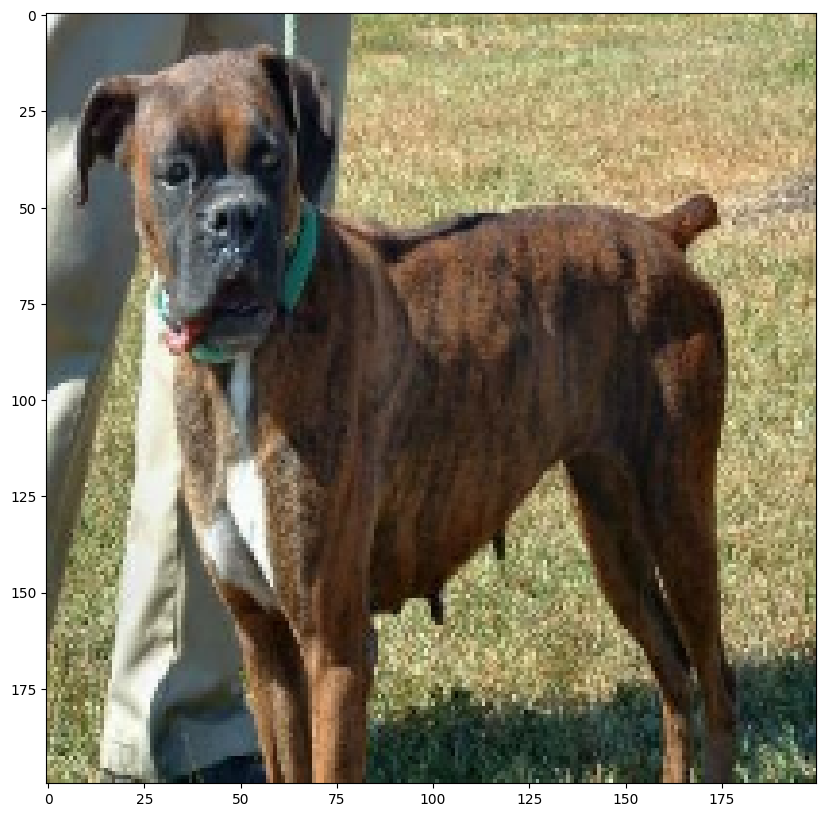

In [18]:
plt.imshow(image)

In [19]:
seed = 42
key = jax.random.PRNGKey(seed)

In [20]:
std_noise = jax.random.normal(key, image.shape)

In [21]:
std_noise.min(), std_noise.max()

(Array(-4.170905, dtype=float32), Array(4.259979, dtype=float32))

In [22]:
noise = 0.5 + 0.1*std_noise

In [23]:
noise.min(), noise.max()

(Array(0.08290949, dtype=float32), Array(0.92599785, dtype=float32))

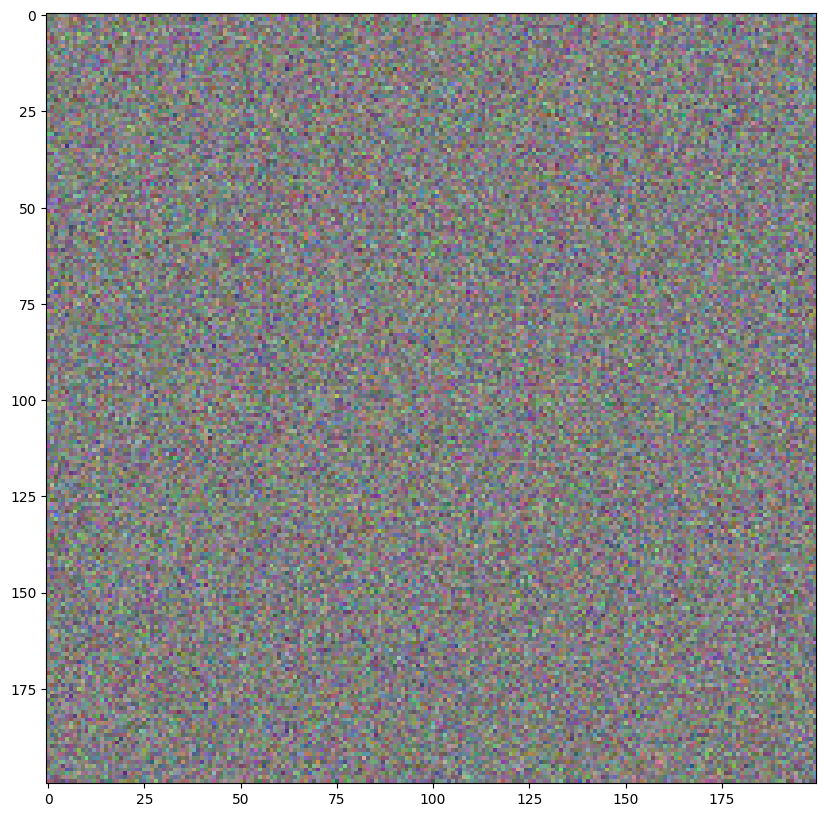

In [24]:
plt.imshow(noise)

In [25]:
new_image = image + noise
new_image.min(), new_image.max()

(Array(0.20670219, dtype=float32), Array(1.7593994, dtype=float32))

In [26]:
new_image = (new_image - new_image.min())/(new_image.max() - new_image.min())

In [27]:
new_image.min(), new_image.max()

(Array(0., dtype=float32), Array(1., dtype=float32))

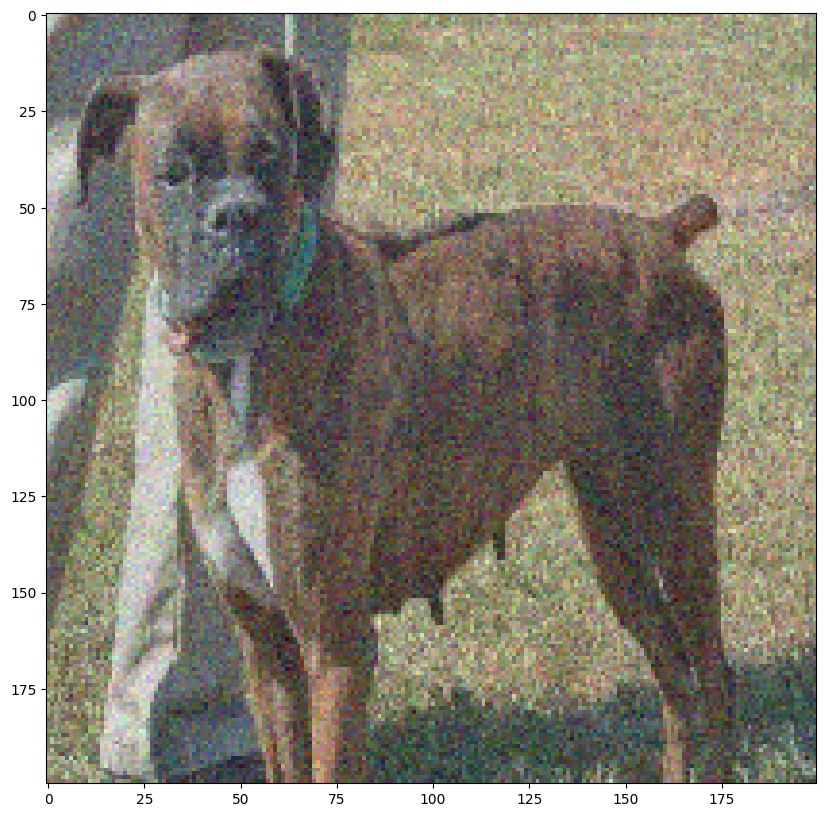

In [28]:
plt.imshow(new_image)

# Doing horizontal flip

In [29]:
image_flipped = image[:,::-1,:]

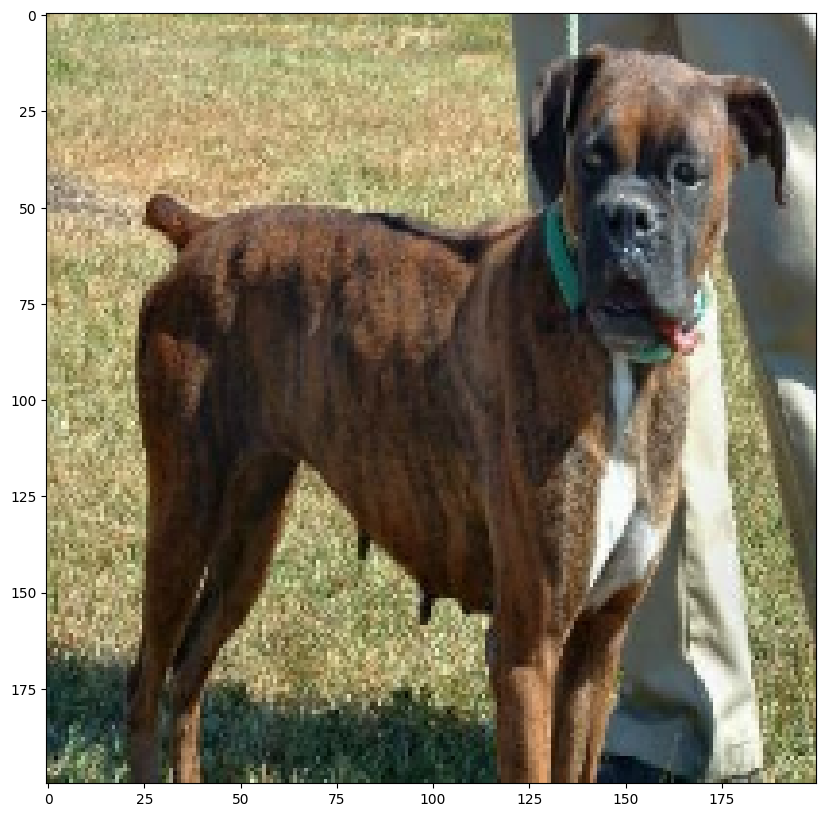

In [30]:
plt.imshow(image_flipped)

In [31]:
image_flipped = jnp.fliplr(image)

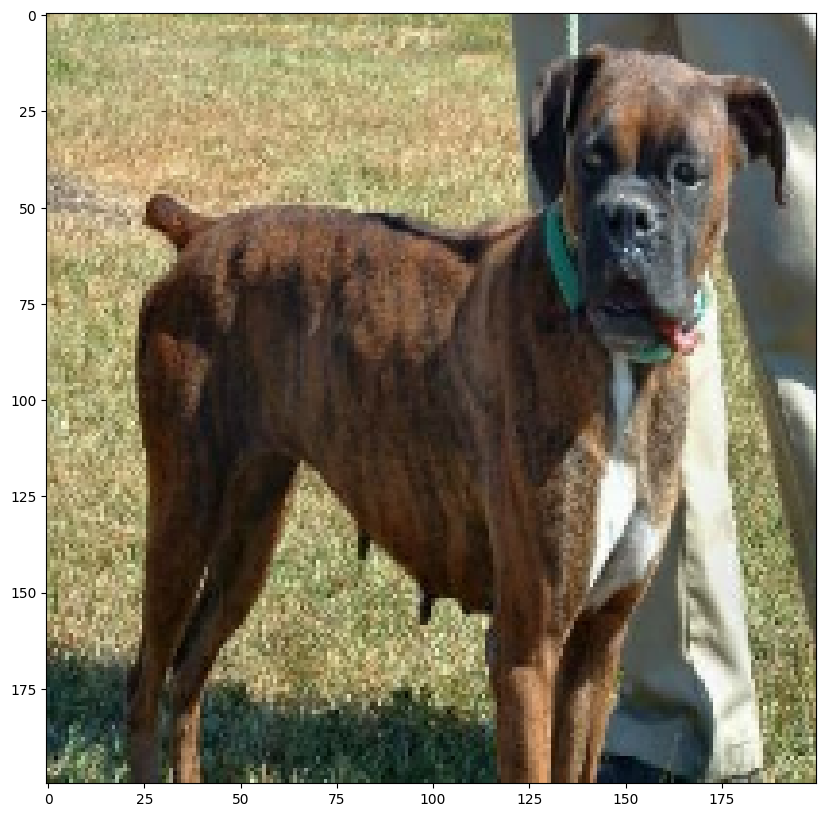

In [32]:
plt.imshow(image_flipped)

# Performing random augmentations

In [33]:
key

Array([ 0, 42], dtype=uint32)

In [34]:
key1, key2 = jax.random.split(key)

In [35]:
key1

Array([2465931498, 3679230171], dtype=uint32)

In [36]:
key2

Array([255383827, 267815257], dtype=uint32)

In [37]:
def add_noise_func(image, rng_key):
  noise = 0.5 + 0.1*jax.random.normal(rng_key, image.shape)
  new_image = image + noise
  new_image = (new_image - new_image.min())/(new_image.max() - new_image.min())
  return new_image

def horizontal_flip_func(image, rng_key):
  return jnp.fliplr(image)

In [38]:
augmentations = [
   add_noise_func,
   horizontal_flip_func
]

In [39]:
def random_augmentation(image, augmentations, rng_key):
   key1, key2 = jax.random.split(rng_key)
   augmentation_index = jax.random.randint(
       key=key1, minval=0, maxval=len(augmentations), shape=())
   augmented_image = jax.lax.switch(augmentation_index, augmentations, image, key2)
   return augmented_image


In [40]:
key = jax.random.PRNGKey(4245)    # <-- change this number to try the function

In [41]:
img = random_augmentation(image, augmentations, key)

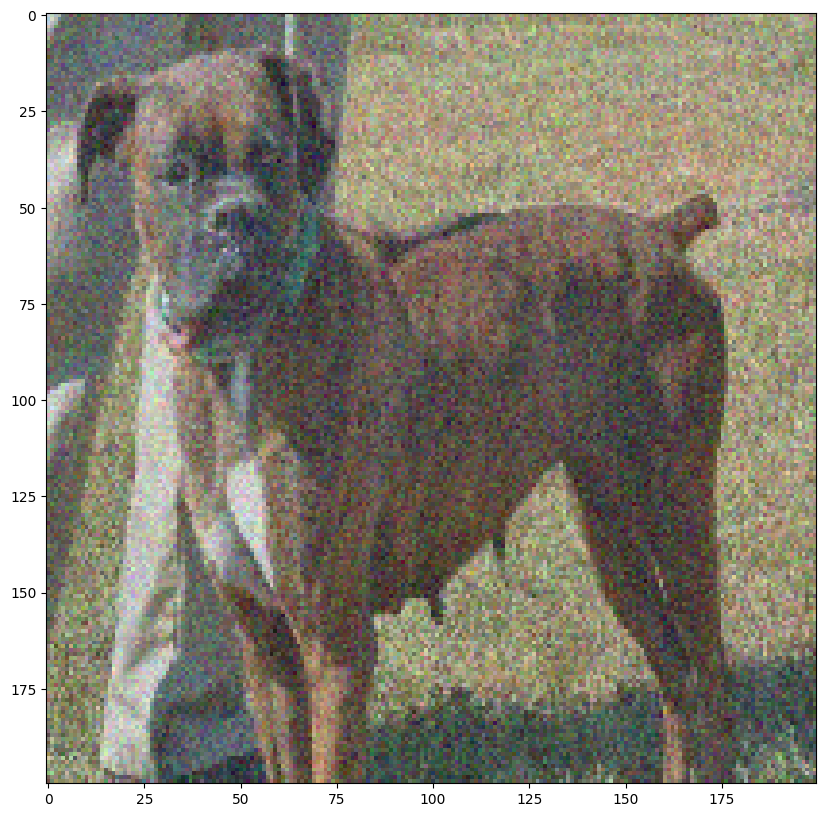

In [42]:
plt.imshow(img)

# NumPy PRNG

In [43]:
import numpy as np

Lecacy NumPy (<1.17.0) https://numpy.org/doc/stable/reference/random/legacy.html

In [44]:
from numpy import random
vals = random.normal(loc=0.5, scale=0.1, size=(3,5))
more_vals = random.normal(loc=0.5, scale=0.1, size=(3,5))

In [45]:
vals

array([[0.63553107, 0.42726091, 0.53119431, 0.71003981, 0.63566762],
       [0.63564426, 0.40181192, 0.41957835, 0.59473428, 0.70761274],
       [0.52452662, 0.53447538, 0.49329323, 0.45048864, 0.50328872]])

In [46]:
more_vals

array([[0.55072002, 0.50932118, 0.57632638, 0.49646044, 0.53409209],
       [0.46280805, 0.26220633, 0.36157547, 0.4418161 , 0.41516823],
       [0.5532511 , 0.67093231, 0.55591697, 0.37461685, 0.43335868]])

New NumPy (>=1.17.0) https://numpy.org/doc/stable/reference/random/

In [47]:
from numpy.random import default_rng
rng = default_rng()
vals = rng.normal(loc=0.5, scale=0.1, size=(3,5))
more_vals = rng.normal(loc=0.5, scale=0.1, size=(3,5))

In [48]:
vals

array([[0.56137324, 0.44466046, 0.5893659 , 0.61205997, 0.6193123 ],
       [0.65082779, 0.51080877, 0.53578511, 0.54630861, 0.51863191],
       [0.56442703, 0.47282842, 0.50779404, 0.50086745, 0.31832372]])

In [49]:
more_vals

array([[0.57164791, 0.27407548, 0.40120443, 0.57804262, 0.71525482],
       [0.54323108, 0.47470028, 0.49026204, 0.356661  , 0.72460425],
       [0.56942963, 0.55776332, 0.647343  , 0.58100687, 0.59295871]])

Controling seed

In [50]:
random.seed(42)
vals = random.normal(loc=0.5, scale=0.1, size=(3,5))
random.seed(42)
more_vals = random.normal(loc=0.5, scale=0.1, size=(3,5))
random.seed(42)
even_more_vals = np.array(
    [random.normal(loc=0.5, scale=0.1) for i in range(3*5)]
).reshape((3,5))

In [51]:
vals

array([[0.54967142, 0.48617357, 0.56476885, 0.65230299, 0.47658466],
       [0.4765863 , 0.65792128, 0.57674347, 0.45305256, 0.554256  ],
       [0.45365823, 0.45342702, 0.52419623, 0.30867198, 0.32750822]])

In [52]:
more_vals

array([[0.54967142, 0.48617357, 0.56476885, 0.65230299, 0.47658466],
       [0.4765863 , 0.65792128, 0.57674347, 0.45305256, 0.554256  ],
       [0.45365823, 0.45342702, 0.52419623, 0.30867198, 0.32750822]])

Demonstrates sequential equivalent guarantee:

In [53]:
even_more_vals

array([[0.54967142, 0.48617357, 0.56476885, 0.65230299, 0.47658466],
       [0.4765863 , 0.65792128, 0.57674347, 0.45305256, 0.554256  ],
       [0.45365823, 0.45342702, 0.52419623, 0.30867198, 0.32750822]])

Looking at state:

In [54]:
random.seed(42)

In [55]:
state = random.get_state()

In [56]:
type(state)

tuple

In [57]:
state[0]

'MT19937'

In [58]:
state[1].shape

(624,)

In [59]:
state[2], state[3], state[4]

(624, 0, 0.0)

In [60]:
state

('MT19937',
 array([        42, 3107752595, 1895908407, 3900362577, 3030691166,
        4081230161, 2732361568, 1361238961, 3961642104,  867618704,
        2837705690, 3281374275, 3928479052, 3691474744, 3088217429,
        1769265762, 3769508895, 2731227933, 2930436685,  486258750,
        1452990090, 3321835500, 3520974945, 2343938241,  928051207,
        2811458012, 3391994544, 3688461242, 1372039449, 3706424981,
        1717012300, 1728812672, 1688496645, 1203107765, 1648758310,
         440890502, 1396092674,  626042708, 3853121610,  669844980,
        2992565612,  310741647, 3820958101, 3474052697,  305511342,
        2053450195,  705225224, 3836704087, 3293527636, 1140926340,
        2738734251,  574359520, 1493564308,  269614846,  427919468,
        2903547603, 2957214125,  181522756, 4137743374, 2557886044,
        3399018834, 1348953650, 1575066973, 3837612427,  705360616,
        4138204617, 1604205300, 1605197804,  590851525, 2371419134,
        2530821810, 4183626679, 2872

In [61]:
vals = random.normal(loc=0.5, scale=0.1, size=(3,5))

In [62]:
state = random.get_state()

In [63]:
state[1].shape

(624,)

In [64]:
state

('MT19937',
 array([ 723970371, 1229153189, 4170412009, 2042542564, 3342822751,
        3177601514, 1210243767, 2648089330, 1412570585, 3849763494,
        2465546753, 1778048360, 3414291523, 3703604926,   37084547,
        2893685227, 1573484469, 1285239205,  699098282, 4130757601,
         396734834, 4180643673, 4141803214, 1198799333,  762411010,
         293648282, 3223568971, 2632094559,  537008479,  741113140,
        4002027498, 2746025092, 2845827535,  548633203,  597320396,
         226799258, 2181165042,  904759057, 3103716301, 1585056142,
        3155542442, 3259059392, 1167550120,  812911362,  759436139,
        1996668977, 2730210635, 1115075517, 2131032978, 3760827332,
        1682941722, 3630150104, 1098113545, 3998782595, 1774436391,
        3953281111,  968975481, 2255177679,  147678039, 1081024905,
         191693936, 2141551523, 2194751066, 2492407928, 2331796867,
        1034855452, 2101471620, 1930706450, 2774870738, 3742117124,
        3410246986,  738426812, 1576

Using seed and state in the new NumPy approach:

In [65]:
from numpy.random import default_rng

In [66]:
rng = default_rng(42)
rng.bit_generator.state

{'bit_generator': 'PCG64',
 'state': {'state': 274674114334540486603088602300644985544,
  'inc': 332724090758049132448979897138935081983},
 'has_uint32': 0,
 'uinteger': 0}

In [67]:
vals = rng.normal(loc=0.5, scale=0.1, size=(3,5))

In [68]:
rng.bit_generator.state

{'bit_generator': 'PCG64',
 'state': {'state': 45342206775459714514805635519735197061,
  'inc': 332724090758049132448979897138935081983},
 'has_uint32': 0,
 'uinteger': 0}

In [69]:
vals

array([[0.53047171, 0.39600159, 0.57504512, 0.59405647, 0.30489648],
       [0.36978205, 0.51278404, 0.46837574, 0.49831988, 0.41469561],
       [0.5879398 , 0.57777919, 0.50660307, 0.61272412, 0.54675093]])

In [70]:
from numpy.random import Generator, PCG64

In [71]:
rng = Generator(PCG64(42))
vals = rng.normal(loc=0.5, scale=0.1, size=(3,5))

In [72]:
rng.bit_generator.state

{'bit_generator': 'PCG64',
 'state': {'state': 45342206775459714514805635519735197061,
  'inc': 332724090758049132448979897138935081983},
 'has_uint32': 0,
 'uinteger': 0}

In [73]:
vals

array([[0.53047171, 0.39600159, 0.57504512, 0.59405647, 0.30489648],
       [0.36978205, 0.51278404, 0.46837574, 0.49831988, 0.41469561],
       [0.5879398 , 0.57777919, 0.50660307, 0.61272412, 0.54675093]])

In [74]:
more_vals = rng.normal(loc=0.5, scale=0.1, size=(3,5))

In [75]:
more_vals

array([[0.41407075, 0.53687508, 0.40411174, 0.58784503, 0.49500741],
       [0.48151376, 0.43190705, 0.62225413, 0.48454705, 0.45716722],
       [0.46478664, 0.55323092, 0.53654441, 0.54127326, 0.5430821 ]])

In [76]:
rng.bit_generator.state

{'bit_generator': 'PCG64',
 'state': {'state': 153855226693314024343079078081769089374,
  'inc': 332724090758049132448979897138935081983},
 'has_uint32': 0,
 'uinteger': 0}

# JAX PRNG

In [77]:
from jax import random

In [78]:
key = random.PRNGKey(42)

In [79]:
type(key)

jaxlib.xla_extension.ArrayImpl

In [80]:
key

Array([ 0, 42], dtype=uint32)

In [81]:
vals = random.normal(key, shape=(3,5))

In [82]:
vals

Array([[-0.716899  , -0.20865498, -2.5713923 ,  1.0337092 , -1.4035789 ],
       [ 1.3873734 , -0.8396519 ,  0.3010434 ,  0.1421263 , -1.7631724 ],
       [-1.6755073 ,  0.31390068,  0.5912831 ,  0.5325395 , -0.9133108 ]],      dtype=float32)

In [83]:
more_vals = random.normal(key, shape=(3,5))

In [84]:
more_vals

Array([[-0.716899  , -0.20865498, -2.5713923 ,  1.0337092 , -1.4035789 ],
       [ 1.3873734 , -0.8396519 ,  0.3010434 ,  0.1421263 , -1.7631724 ],
       [-1.6755073 ,  0.31390068,  0.5912831 ,  0.5325395 , -0.9133108 ]],      dtype=float32)

Splitting the key to produce multiple keys

In [85]:
key = random.PRNGKey(42)

key1, key2 = random.split(key, num=2)

In [86]:
key

Array([ 0, 42], dtype=uint32)

In [87]:
vals = random.normal(key1, shape=(3,5))
more_vals = random.normal(key2, shape=(3,5))

In [88]:
key1

Array([2465931498, 3679230171], dtype=uint32)

In [89]:
key2

Array([255383827, 267815257], dtype=uint32)

In [90]:
vals

Array([[-0.95032114,  0.89362663, -1.9382219 , -0.9676806 , -0.3920417 ],
       [ 0.6062024 ,  0.37990445,  0.30284515,  1.3282853 ,  1.1882905 ],
       [-0.95166105,  1.2611355 ,  0.41334143, -0.7831721 ,  0.09786294]],      dtype=float32)

In [91]:
more_vals

Array([[ 0.7679137 ,  0.46966743, -1.4884446 , -1.155719  , -1.2574353 ],
       [-0.66447204, -1.3314192 ,  1.5208852 , -0.55124223, -0.3213504 ],
       [ 1.1168208 , -0.4216216 ,  0.32398054,  1.3500887 , -0.22909231]],      dtype=float32)

Generating many keys at once

In [92]:
key = random.PRNGKey(42)
key, *subkeys = random.split(key, num=100)

In [93]:
key

Array([ 825763528, 3327736007], dtype=uint32)

In [94]:
len(subkeys)

99

In [95]:
type(subkeys)

list

Generating new keys using fold_in() (https://github.com/google/jax/discussions/12395#discussioncomment-3703291)

In [96]:
key = random.PRNGKey(42)
for i in range(10):
  new_key = random.fold_in(key, i)
  print(new_key)
  vals = random.normal(new_key, shape=(3,5))
  # do something with values

[1832780943  270669613]
[  64467757 2916123636]
[2465931498  255383827]
[3134548294  894150801]
[2954079971 3276725750]
[2765691542  824333390]
[2768684296 3055579793]
[2547012911 1371500959]
[1016697191 2390192106]
[1128875147 2463678267]


Using a string to fold into a new key

In [97]:
import hashlib

def my_hash(s):
  return int(hashlib.sha1(s.encode()).hexdigest()[:8], base=16)

some_string = 'layer7_2'
some_int = my_hash(some_string)

In [98]:
some_int

2649017889

In [99]:
key = random.PRNGKey(42)
new_key = random.fold_in(key, some_int)

In [100]:
new_key

Array([3110527424, 3716265121], dtype=uint32)

No sequential equivalent guarantee

In [101]:
import jax.numpy as jnp

key = random.PRNGKey(42)
subkeys = random.split(key, num=3*5)

vals = random.normal(key, shape=(3,5))

more_vals = jnp.array(
    [random.normal(key) for key in subkeys]
).reshape((3,5))

In [102]:
vals

Array([[-0.716899  , -0.20865498, -2.5713923 ,  1.0337092 , -1.4035789 ],
       [ 1.3873734 , -0.8396519 ,  0.3010434 ,  0.1421263 , -1.7631724 ],
       [-1.6755073 ,  0.31390068,  0.5912831 ,  0.5325395 , -0.9133108 ]],      dtype=float32)

In [103]:
more_vals

Array([[-0.46220607, -0.33953536, -1.1038666 ,  0.34873134, -0.577846  ],
       [ 1.9925295 ,  0.02132202,  0.7312121 , -0.40033886, -0.9915146 ],
       [-0.03269025,  1.1624117 ,  0.15050009, -1.3577023 , -1.7751262 ]],      dtype=float32)

# Using experimental PRNGs

In [104]:
from jax.config import config
config.update("jax_default_prng_impl", "rbg")

<ipython-input-104-3df6184f6fea>:1: DeprecationWarning: Accessing jax.config via the jax.config submodule is deprecated.
  from jax.config import config


In [105]:
import jax
from jax import random

In [106]:
key = random.PRNGKey(42)

In [107]:
key

Array([ 0, 42,  0, 42], dtype=uint32)

In [108]:
config.update("jax_default_prng_impl", "unsafe_rbg")

In [109]:
key = random.PRNGKey(42)

In [110]:
key

Array([ 0, 42,  0, 42], dtype=uint32)

In [111]:
config.update("jax_default_prng_impl", "threefry2x32")

In [112]:
key = random.PRNGKey(42)

In [113]:
key

Array([ 0, 42], dtype=uint32)

# Complete data augmentation pipeline

In [114]:
import tensorflow as tf
# Ensure TF does not see GPU and grab all GPU memory.
tf.config.set_visible_devices([], device_type='GPU')

import tensorflow_datasets as tfds

data_dir = '/tmp/tfds'

# As the dataset does not contain any train/test split
# we make our own split into train and test dataset.
# as_supervised=True gives us the (image, label) as a tuple instead of a dict
data, info = tfds.load(name="cats_vs_dogs",
                       data_dir=data_dir,
                       split=["train[:80%]", "train[80%:]"],
                       as_supervised=True,
                       with_info=True)

(cats_dogs_data_train, cats_dogs_data_test) = data

In [115]:
HEIGHT = 200
WIDTH  = 200
CHANNELS = 3
NUM_PIXELS = HEIGHT * WIDTH * CHANNELS
NUM_LABELS = info.features['label'].num_classes

In [116]:
import jax
import jax.numpy as jnp

In [117]:
def one_hot(x, k, dtype=jnp.float32):
  """Create a one-hot encoding of x of size k."""
  return jnp.array(x[:, None] == jnp.arange(k), dtype)

def preprocess(img, label):
  """Resize and preprocess images."""
  return tf.image.resize(img, [HEIGHT, WIDTH]) / 255.0, label

In [118]:
train_data = tfds.as_numpy(cats_dogs_data_train.map(preprocess).batch(32).prefetch(1))
test_data  = tfds.as_numpy(cats_dogs_data_test.map(preprocess).batch(32).prefetch(1))

In [119]:
def add_noise_func(image, rng_key):
  noise = 0.5 + 0.1*jax.random.normal(rng_key, image.shape)
  new_image = image + noise
  new_image = (new_image - new_image.min())/(new_image.max() - new_image.min())
  return new_image

def horizontal_flip_func(image, rng_key):
  return jnp.fliplr(image)

In [120]:
augmentations = [
   add_noise_func,
   horizontal_flip_func
]

In [121]:
def random_augmentation(image, augmentations, rng_key):
   key1, key2 = jax.random.split(rng_key)
   augmentation_index = jax.random.randint(
       key=key1, minval=0, maxval=len(augmentations), shape=())
   augmented_image = jax.lax.switch(augmentation_index, augmentations, image, key2)
   return augmented_image

In [122]:
key = jax.random.PRNGKey(42)

In [123]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]

CLASS_NAMES = ['cat', 'dog']

def display_batch(images, labels, rows, cols, class_labels):
  i = 0
  fig, ax = plt.subplots(rows, cols)
  for i in range(len(images)):
    image = images[i,:,:,:]
    label = labels[i]
    ax[int(i/cols), i%cols].axis('off')
    ax[int(i/cols), i%cols].set_title(class_labels[label])
    ax[int(i/cols), i%cols].imshow(image)
    i += 1
  plt.show()

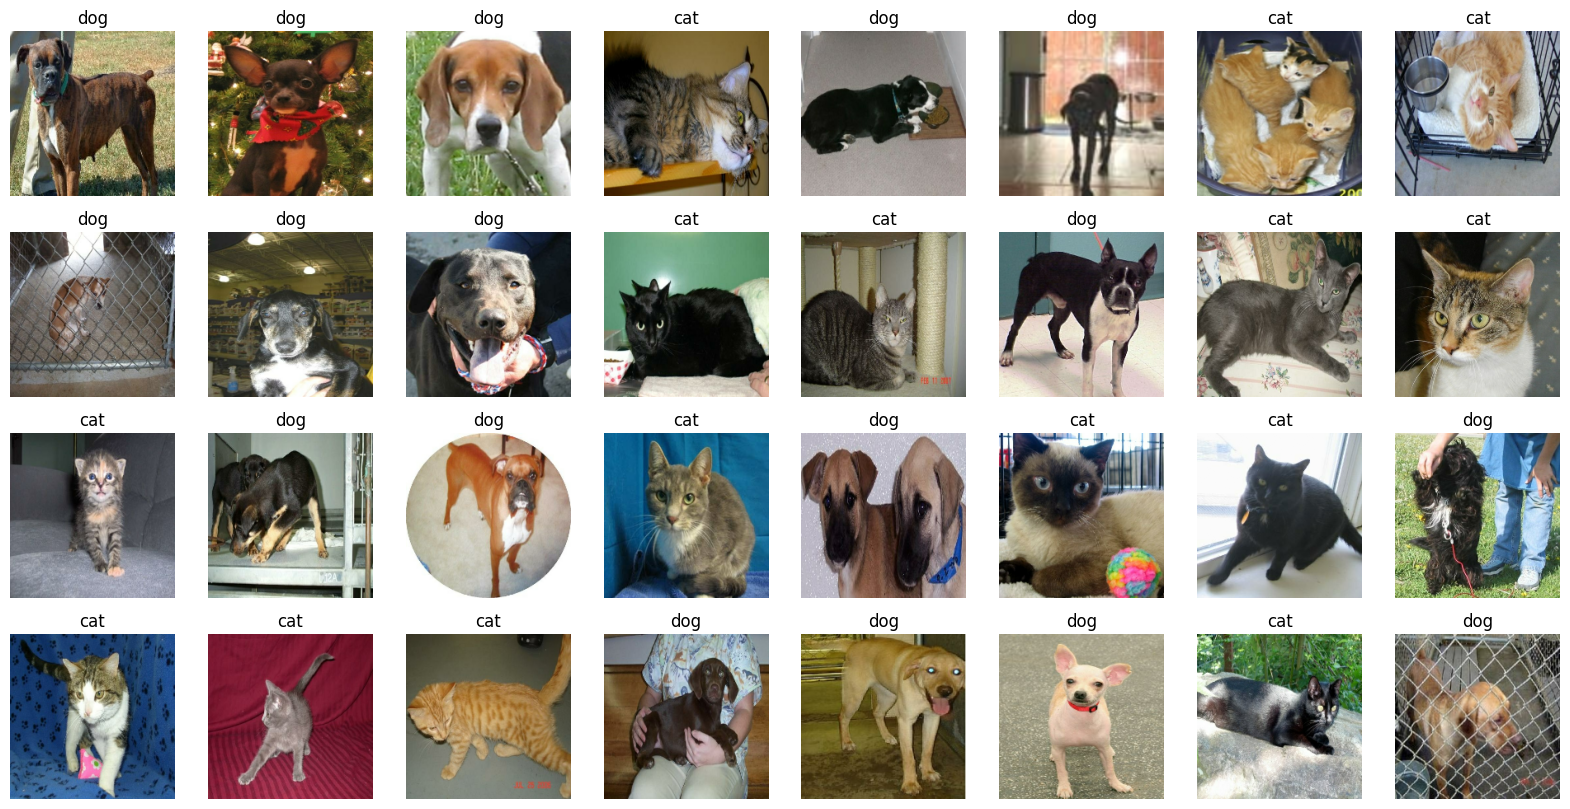

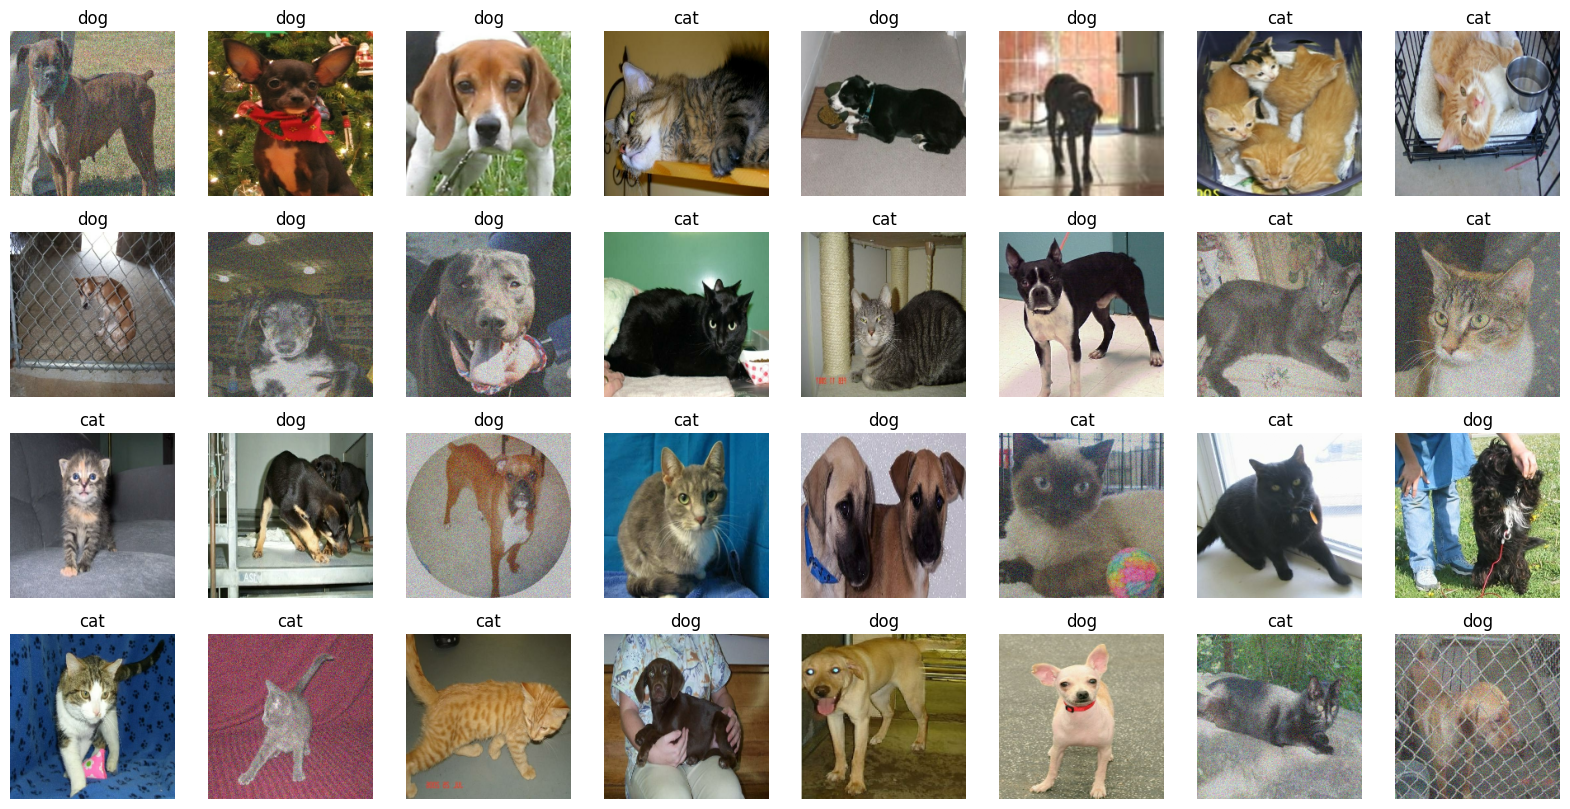

In [124]:
for x, y in train_data:
    display_batch(x, y, 4, 8, CLASS_NAMES)
    batch_size = len(x)
    key, *subkeys = random.split(key, num=batch_size+1)

    aug_x = jax.vmap(random_augmentation, in_axes=(0,None,0))(x, augmentations, jnp.array(subkeys))

    ## unvectorized code
    #augmented_x = []
    #for i in range(batch_size):
    #  img = random_augmentation(x[i,:,:,:], augmentations, subkeys[i])
    #  augmented_x.append(img)
    #aug_x = jnp.stack(augmented_x, axis=0)
    #print(x.shape, aug_x.shape)

    display_batch(aug_x, y, 4, 8, CLASS_NAMES)
    ## do some training
    #x = jnp.reshape(aug_x, (len(aug_x), NUM_PIXELS))
    #y = one_hot(y, NUM_LABELS)
    # params = update(params, x, y, epoch)
    break


# Generating random initializations for a neural network

In [125]:
LAYER_SIZES = [200*200*3, 2048, 1024, 2]
PARAM_SCALE = 0.01

In [126]:
import jax.numpy as jnp
from jax import random

In [127]:
def random_layer_params(m, n, key, scale=1e-2):
  """A helper function to randomly initialize weights and biases of a dense layer"""
  w_key, b_key = random.split(key)
  return scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))

def init_network_params(sizes, key=random.PRNGKey(0), scale=0.01):
  """Initialize all layers for a fully-connected neural network with given sizes"""
  keys = random.split(key, len(sizes)-1)
  return [random_layer_params(m, n, k, scale) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

In [128]:
key = random.PRNGKey(42)

In [129]:
params = init_network_params(LAYER_SIZES, key, scale=PARAM_SCALE)